# Lab 1 GPT code

Середнє y: 0.0012, σ(y): 0.1581
   p  q    R2_OLS    R2_RLS   SSE_OLS   SSE_RLS      AIC_OLS      AIC_RLS
0  1  1  0.557247  0.519915  5.531578  5.997983 -2242.564382 -2202.170278
1  1  2  0.559779  0.508910  5.499940  6.135474 -2237.919723 -2183.463372
2  1  3  0.604133  0.565581  4.945038  5.426619 -2283.272086 -2237.085029
3  2  1  0.612564  0.565398  4.840474  5.429744 -2301.526515 -2244.316597
4  2  2  0.616467  0.554017  4.791701  5.571929 -2304.569896 -2229.443670
5  2  3  0.619616  0.575964  4.751633  5.296920 -2301.100576 -2247.107831
6  3  1  0.618258  0.561153  4.768593  5.481924 -2301.329770 -2232.045568
7  3  2  0.619616  0.553408  4.751633  5.578675 -2301.100576 -2221.350444
8  3  3  0.619616  0.574289  4.751633  5.317842 -2299.100576 -2243.148638


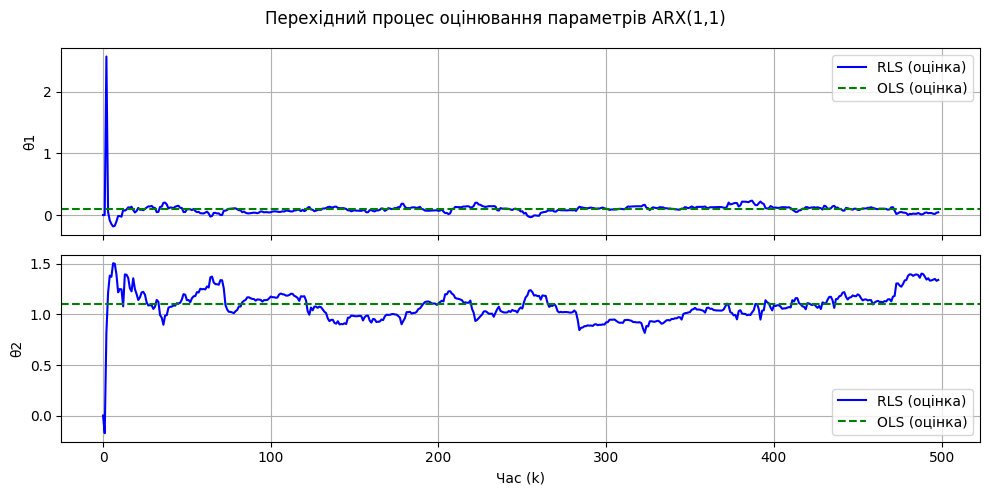

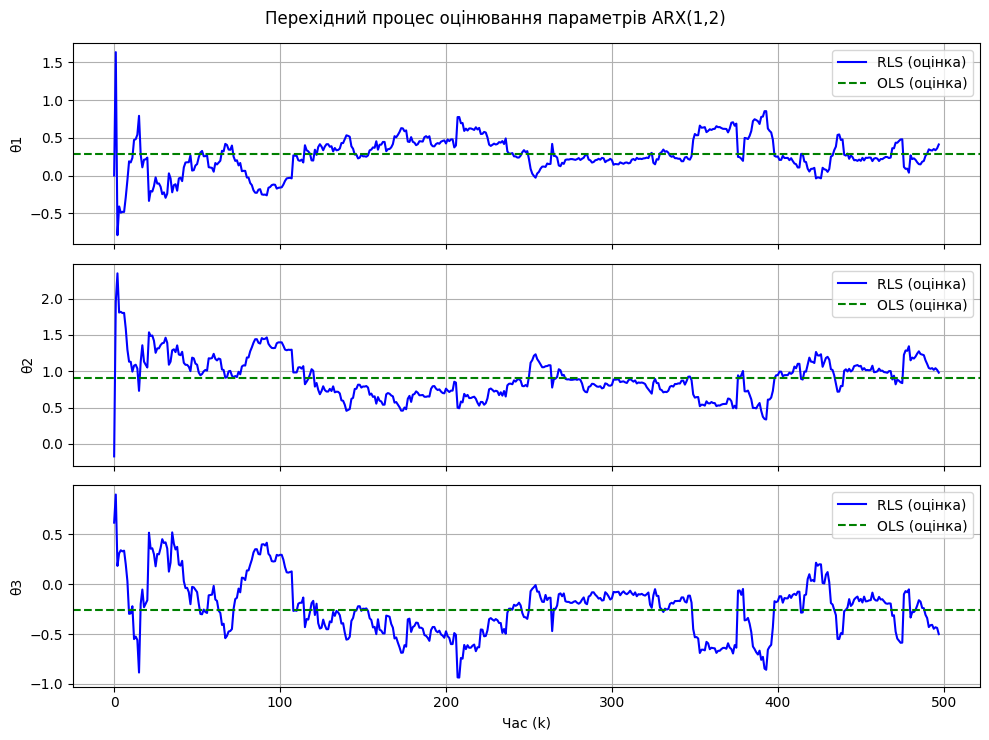

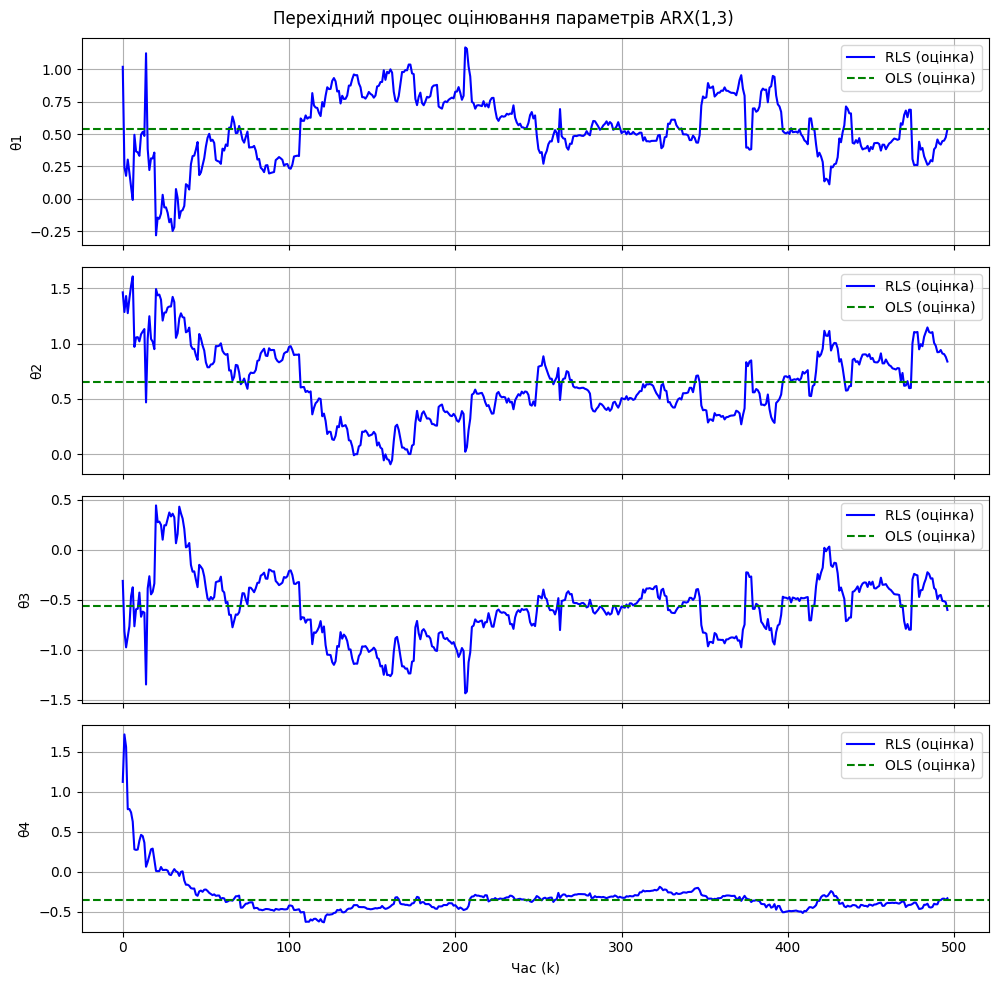

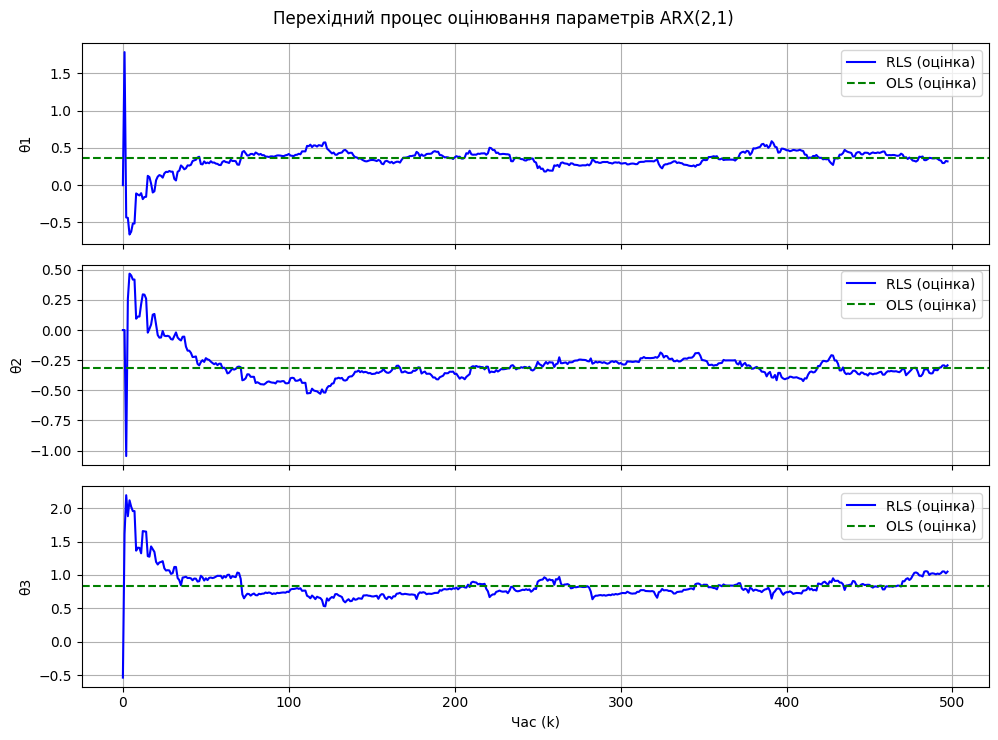

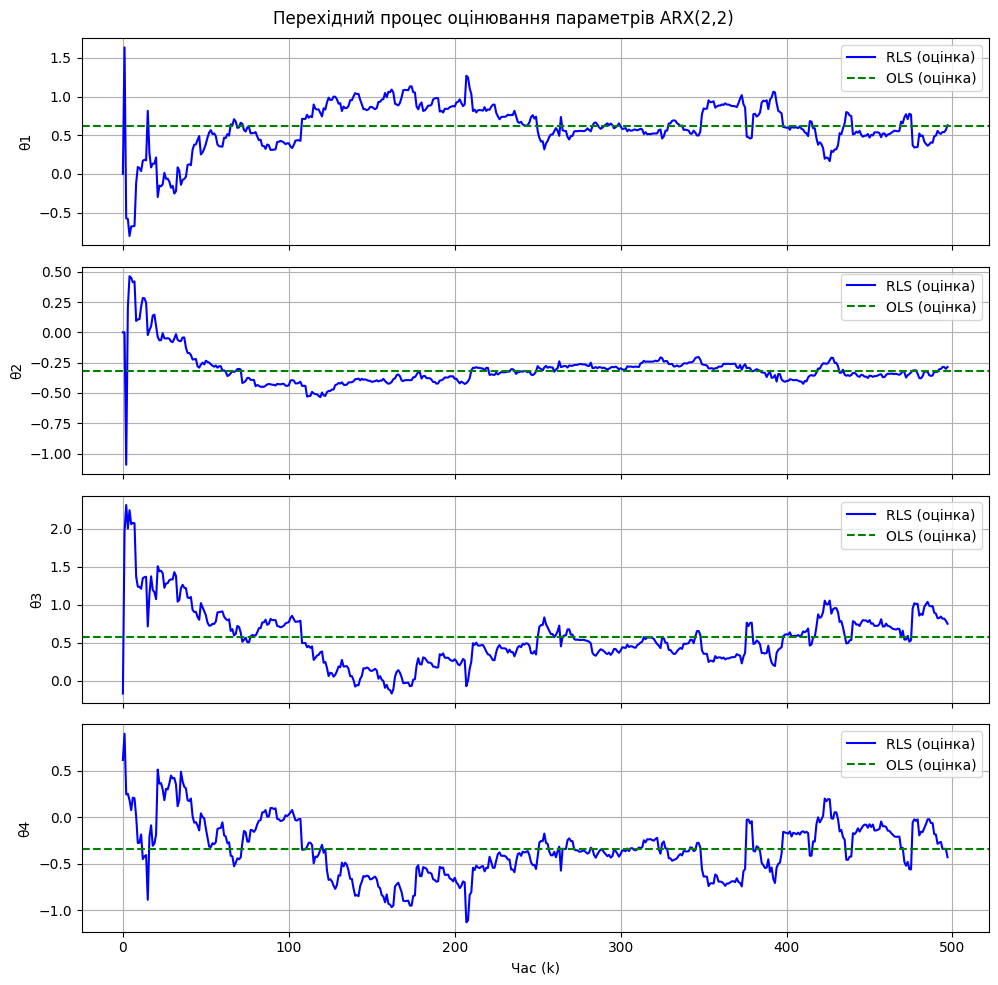

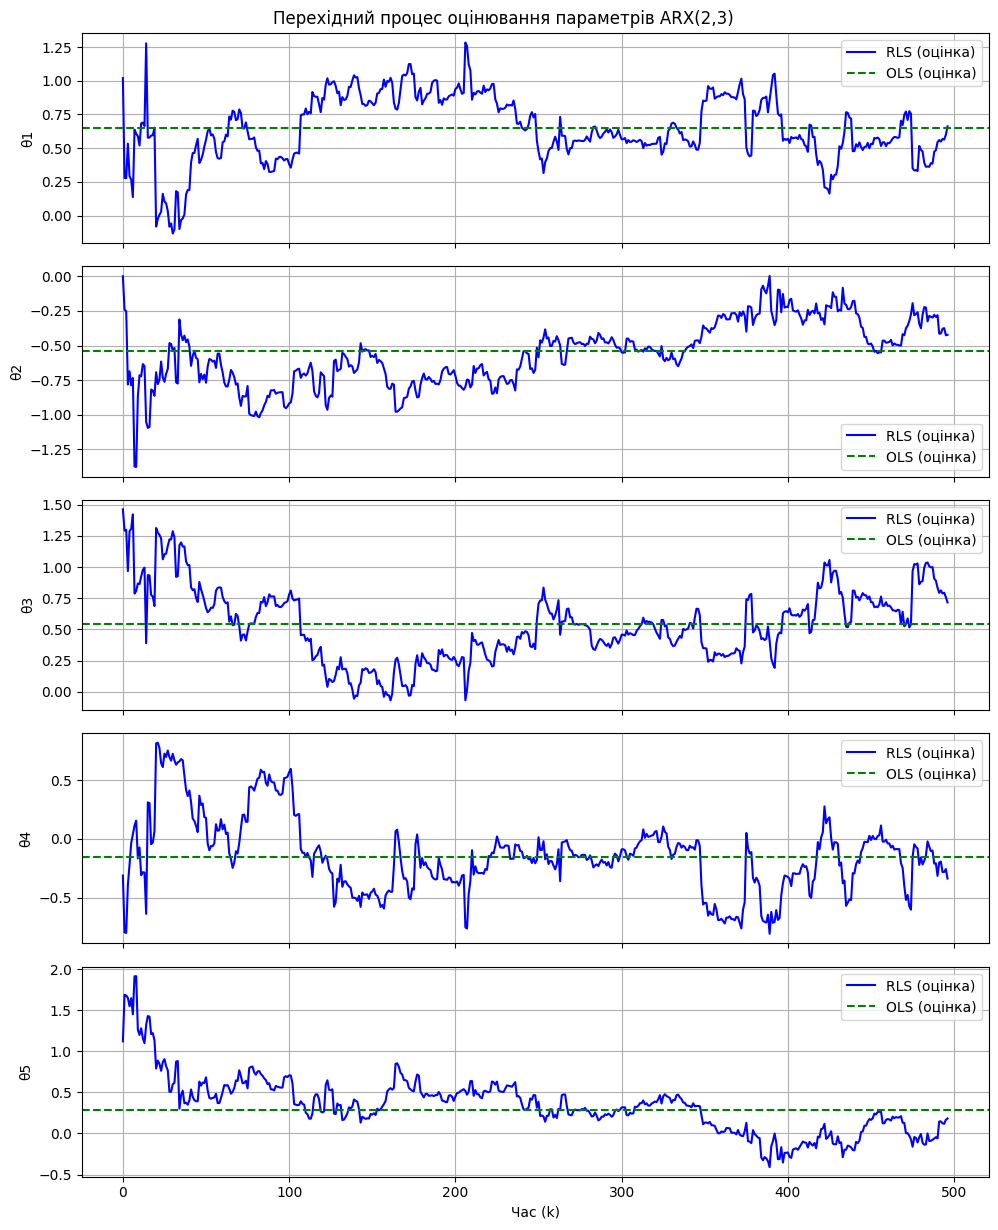

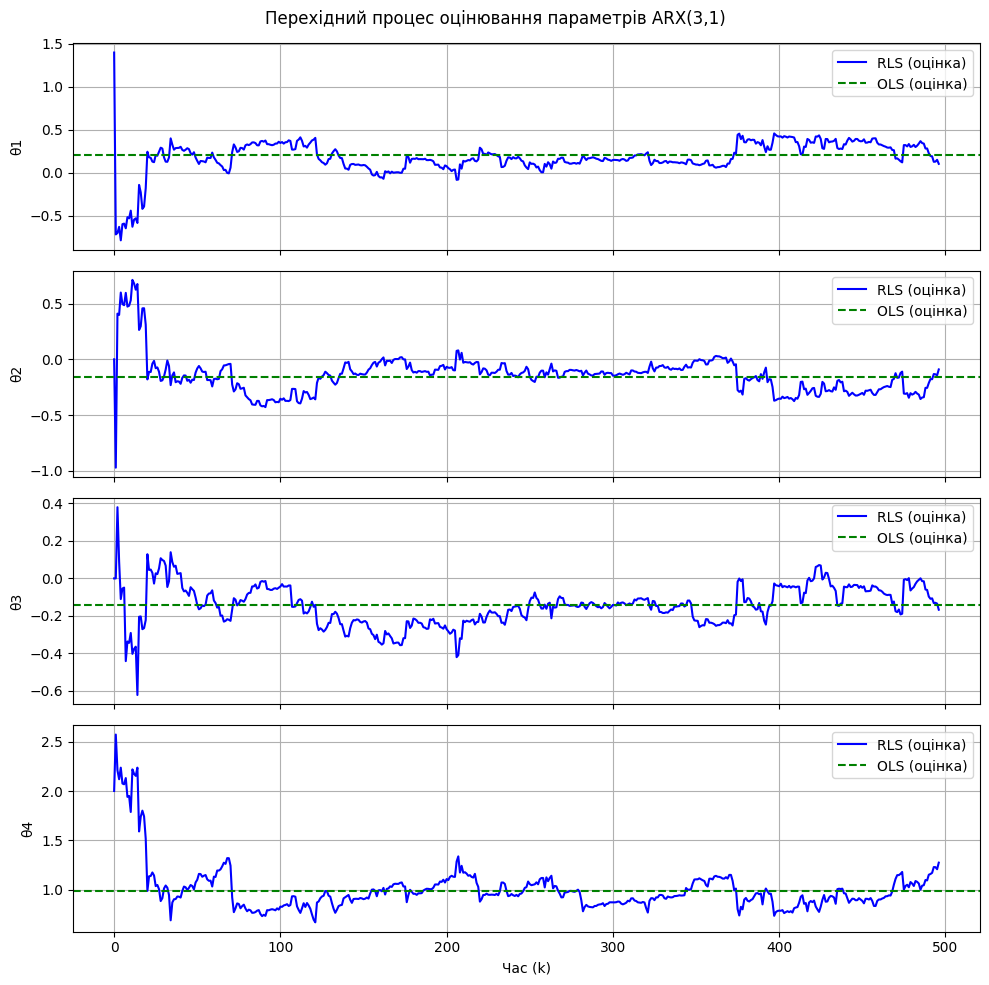

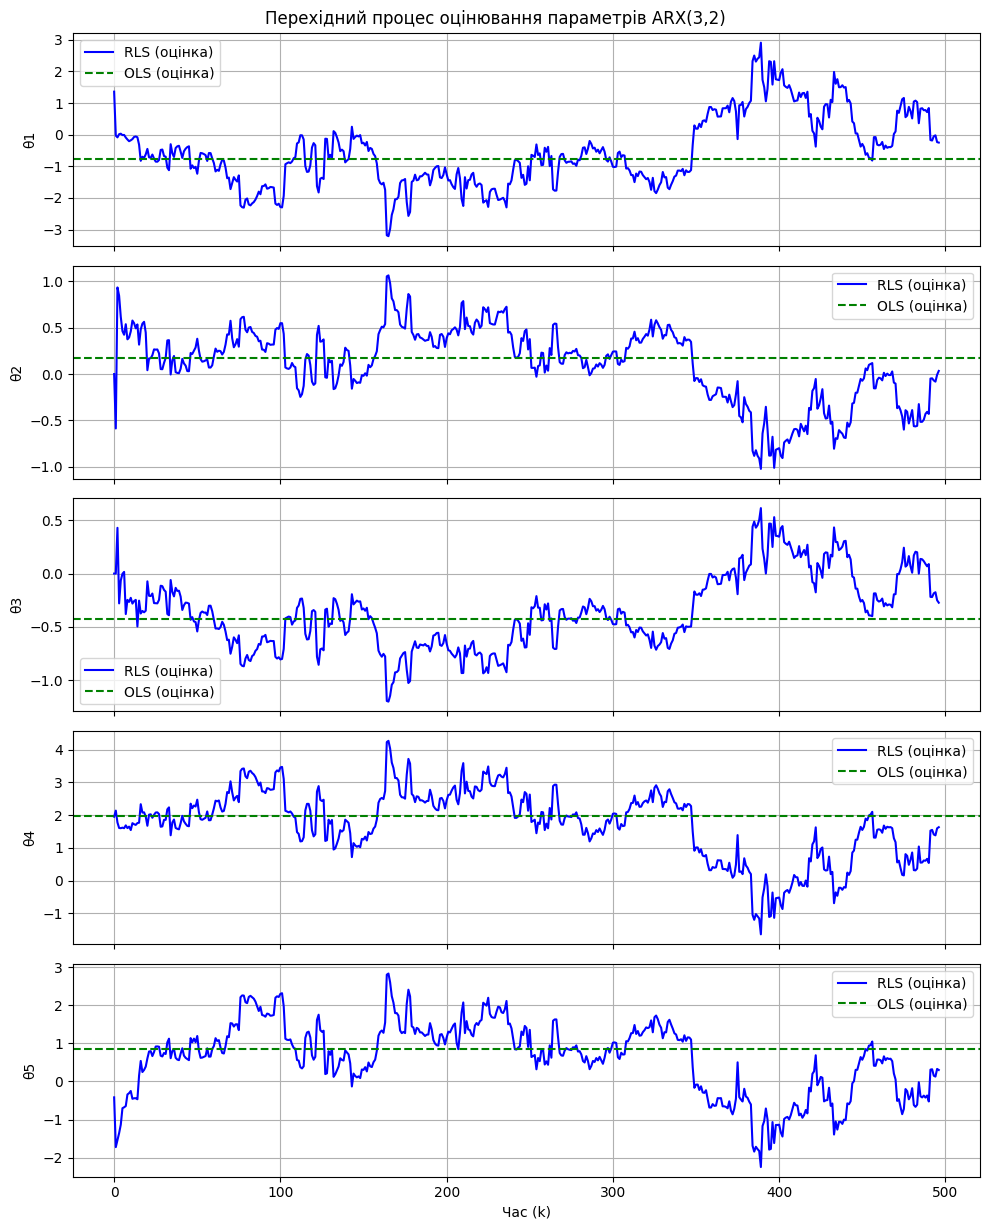

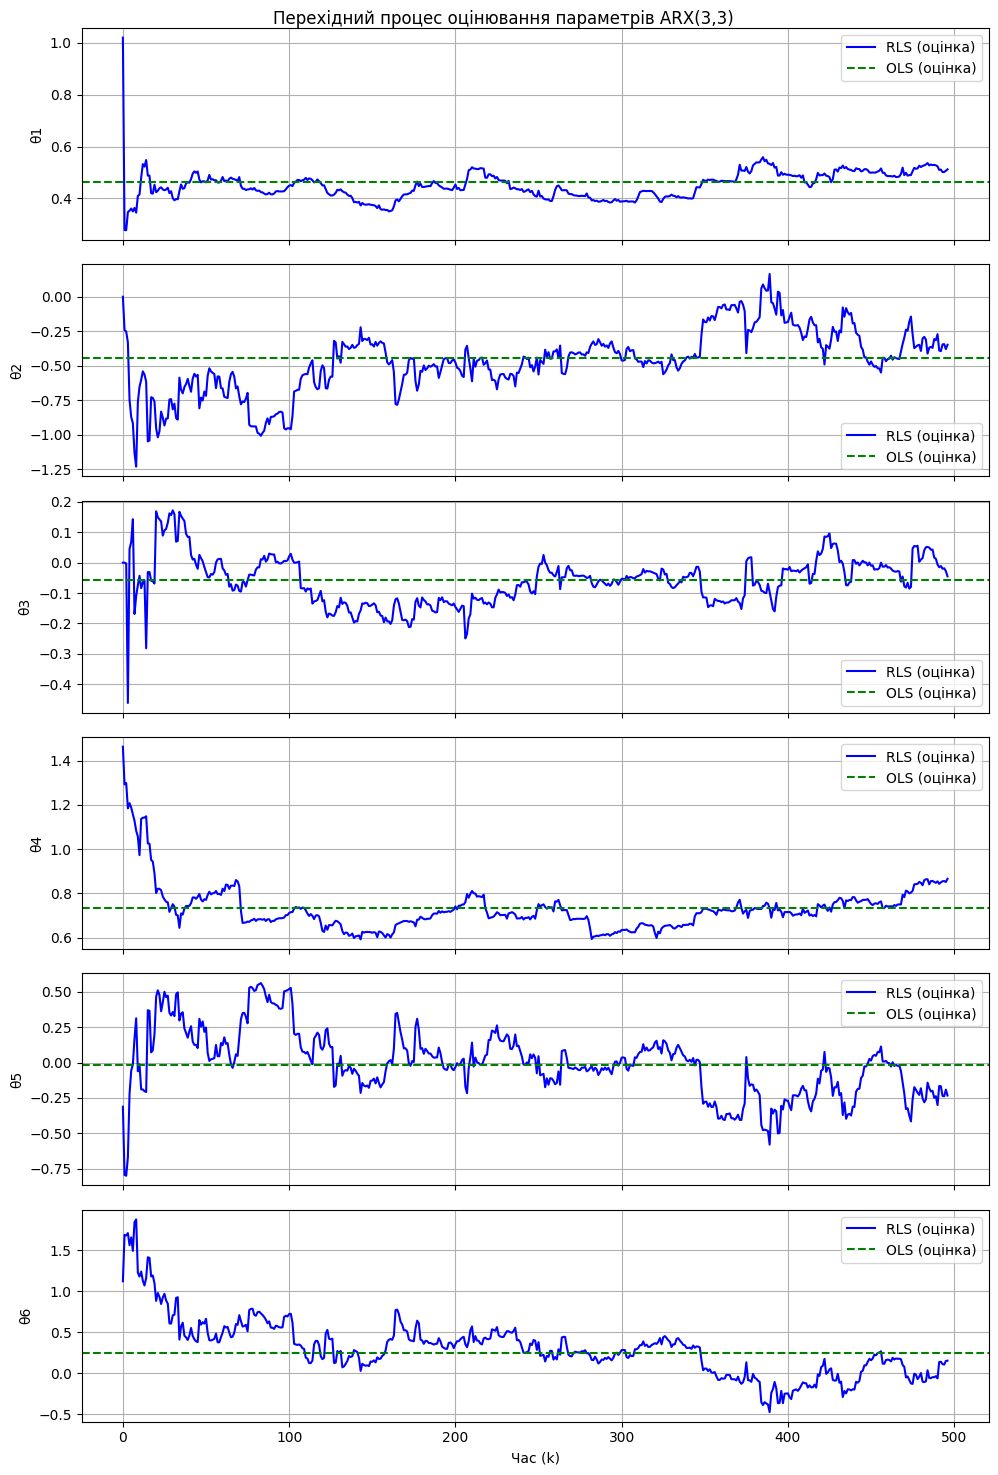

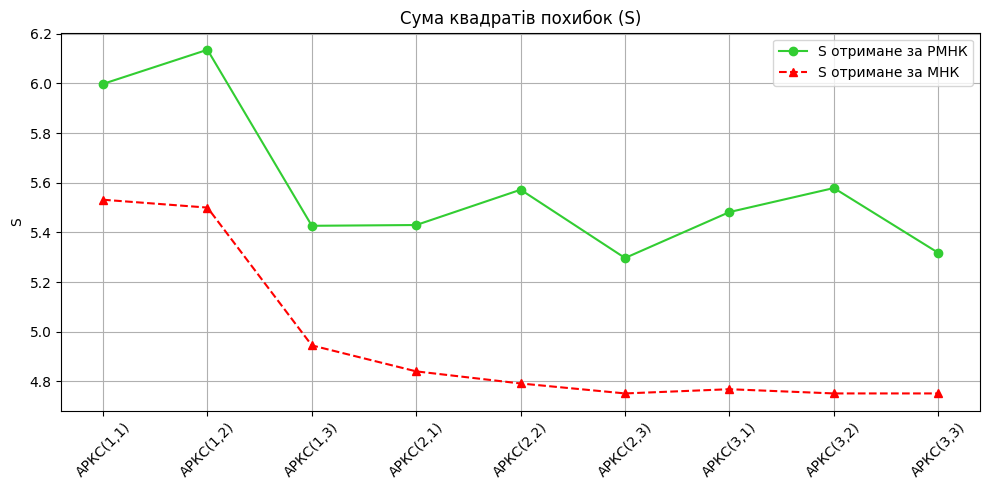

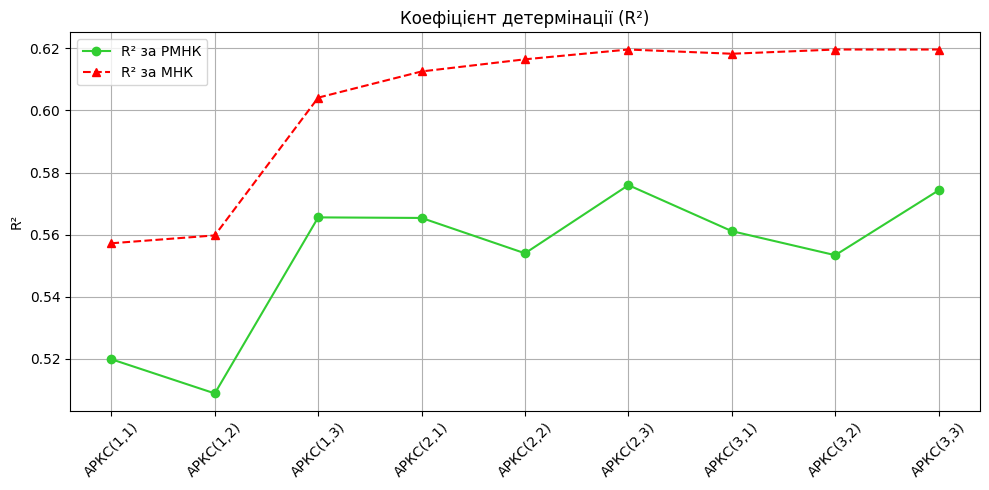

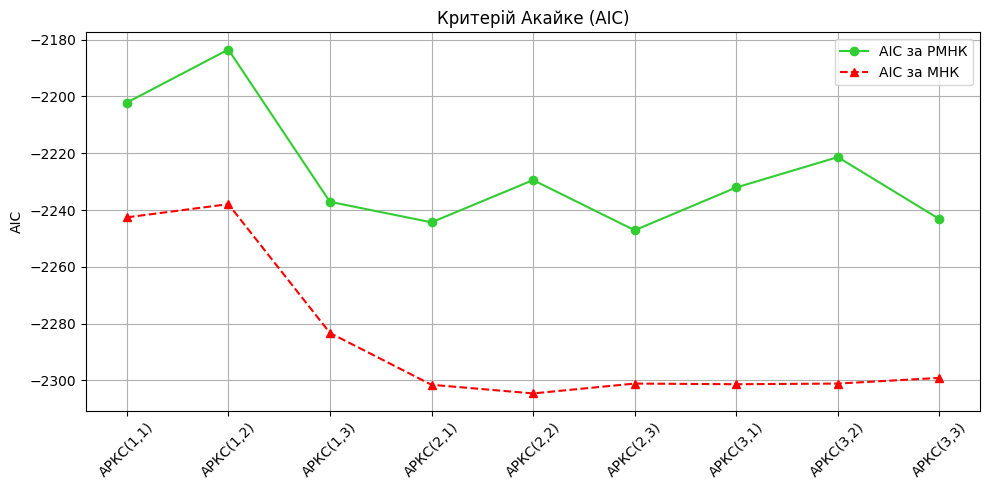


Результати збережені у results_models.xlsx


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# 1. Генерація або завантаження даних
# ----------------------------
def generate_data(n=500, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, 0.1, n)
    y = np.zeros(n)
    # приклад стабільної ARMA(2,2) системи
    a = [0.5, -0.3]
    b = [0.7, -0.2]
    for t in range(max(len(a), len(b)), n):
        y[t] = (a[0]*y[t-1] + a[1]*y[t-2] +
                b[0]*v[t-1] + b[1]*v[t-2] + v[t])
    return y, v

def load_or_generate():
    y_file, v_file = Path("y_generated.txt"), Path("v_generated.txt")
    if y_file.exists() and v_file.exists():
        y = np.loadtxt(y_file)
        v = np.loadtxt(v_file)
    else:
        y, v = generate_data()
        np.savetxt(y_file, y)
        np.savetxt(v_file, v)
        print("Файли не знайдено. Згенеровано синтетичні дані і збережено.")
    return y, v

y, v = load_or_generate()
print(f"Середнє y: {y.mean():.4f}, σ(y): {y.std():.4f}")

# ----------------------------
# 2. Побудова матриці регресорів
# ----------------------------
def design_matrix(y, v, p, q):
    n = len(y)
    m = max(p, q)
    X, Y = [], []
    for t in range(m, n):
        row = []
        # AR частина
        for i in range(1, p+1):
            row.append(y[t-i])
        # MA частина
        for j in range(1, q+1):
            row.append(v[t-j])
        X.append(row)
        Y.append(y[t])
    return np.array(X), np.array(Y)

# ----------------------------
# 3. Методи оцінки
# ----------------------------
def ols_estimation(X, Y):
    theta = np.linalg.lstsq(X, Y, rcond=None)[0]
    y_hat = X @ theta
    e = Y - y_hat
    return theta, e
    

def rls_estimation(X, Y, lam=0.98, delta=1000):
    n_samples, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    thetas = np.zeros((n_samples, n_params))
    errors = np.zeros(n_samples)

    for k in range(n_samples):
        xk = X[k].reshape(-1, 1)
        yk = Y[k]

        # Калманівський крок
        denom = lam + xk.T @ P @ xk
        K = (P @ xk / denom).flatten()

        err = (yk - xk.T @ theta.reshape(-1,1)).item()
        theta = theta + K * err
        P = (P - np.outer(K, xk.T @ P)) / lam

        thetas[k] = theta
        errors[k] = err

    return theta, errors, thetas


# ----------------------------
# 4. Перебір моделей p=1..3, q=1..3
# ----------------------------
results = []
rls_paths = {}  # для перехідних процесів

for p in range(1,4):
    for q in range(1,4):
        X, Y = design_matrix(y, v, p, q)

        # OLS
        th_ols, e_ols = ols_estimation(X, Y)

        # RLS
        th_rls, e_rls, thetas_path = rls_estimation(X, Y)
        rls_paths[(p,q)] = thetas_path

        n = len(Y)
        k = p + q
        sse_ols = np.sum(e_ols**2)
        sse_rls = np.sum(e_rls**2)
        r2_ols = 1 - sse_ols/np.sum((Y - Y.mean())**2)
        r2_rls = 1 - sse_rls/np.sum((Y - Y.mean())**2)
        aic_ols = n*np.log(sse_ols/n) + 2*k
        aic_rls = n*np.log(sse_rls/n) + 2*k

        results.append({
            'p': p, 'q': q,
            'R2_OLS': r2_ols,
            'R2_RLS': r2_rls,
            'SSE_OLS': sse_ols,
            'SSE_RLS': sse_rls,
            'AIC_OLS': aic_ols,
            'AIC_RLS': aic_rls
        })

res_df = pd.DataFrame(results)
print(res_df)

# ----------------------------
# 5. Графіки перехідного процесу РМНК
# ----------------------------
def plot_rls_transients(rls_paths, ols_thetas, true_params=None):
    import matplotlib.pyplot as plt

    for (p, q), thetas in rls_paths.items():
        k_total, n_params = thetas.shape
        fig, axes = plt.subplots(n_params, 1, figsize=(10, 2.5 * n_params), sharex=True)

        if n_params == 1:
            axes = [axes]  # уніфікація, навіть якщо 1 графік

        time = np.arange(k_total)

        for i in range(n_params):
            axes[i].plot(time, thetas[:, i], label='RLS (оцінка)', color='blue')
            axes[i].axhline(ols_thetas[(p, q)][i], color='green', linestyle='--', label='OLS (оцінка)')
            if true_params is not None:
                axes[i].axhline(true_params.get((p, q, i), 0), color='red', linestyle=':', label='Істинне значення')

            axes[i].set_ylabel(f'θ{i+1}')
            axes[i].grid(True)
            axes[i].legend()

        axes[-1].set_xlabel('Час (k)')
        fig.suptitle(f'Перехідний процес оцінювання параметрів ARX({p},{q})')
        plt.tight_layout()
        plt.show()

# Підготуємо словник для порівняння з оцінками МНК
ols_thetas = {}
for p in range(1, 4):
    for q in range(1, 4):
        X, Y = design_matrix(y, v, p, q)
        th_ols, _ = ols_estimation(X, Y)
        ols_thetas[(p, q)] = th_ols

# Якщо є істинні параметри для вашої бригади — додайте ось тут (приклад)
# true_params = {(3,3,0): 0.0, (3,3,1): 0.22, ..., (3,3,5): 0.25}

plot_rls_transients(rls_paths, ols_thetas, true_params=None)



# ----------------------------
# 6. Графіки залежностей R2, SSE, AIC
# ----------------------------
def plot_model_comparison(res_df):
    import matplotlib.pyplot as plt

    # Вісь X: мітки моделей
    models = [f"АРКС({p},{q})" for p, q in zip(res_df['p'], res_df['q'])]

    # ---- 1. Графік суми квадратів похибок (SSE) ----
    plt.figure(figsize=(10, 5))
    plt.plot(models, res_df['SSE_RLS'], marker='o', color='limegreen', label='S отримане за РМНК')
    plt.plot(models, res_df['SSE_OLS'], marker='^', color='red', linestyle='--', label='S отримане за МНК')
    plt.title('Сума квадратів похибок (S)')
    plt.ylabel('S')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 2. Графік коефіцієнта детермінації (R²) ----
    plt.figure(figsize=(10, 5))
    plt.plot(models, res_df['R2_RLS'], marker='o', color='limegreen', label='R² за РМНК')
    plt.plot(models, res_df['R2_OLS'], marker='^', color='red', linestyle='--', label='R² за МНК')
    plt.title('Коефіцієнт детермінації (R²)')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 3. Графік критерію Акайке (AIC) ----
    plt.figure(figsize=(10, 5))
    plt.plot(models, res_df['AIC_RLS'], marker='o', color='limegreen', label='AIC за РМНК')
    plt.plot(models, res_df['AIC_OLS'], marker='^', color='red', linestyle='--', label='AIC за МНК')
    plt.title('Критерій Акайке (AIC)')
    plt.ylabel('AIC')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_model_comparison(res_df)

# Збереження у файл
res_df.to_excel('results_models.xlsx', index=False)
print("\nРезультати збережені у results_models.xlsx")
